# Setup

In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

import torch.nn.functional as F

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: StepLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  # Update scheduler
  scheduler.step()

In [4]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader, 
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False, 
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.) 

In [5]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define pruning functions.

In [6]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = round(num_elements * sparsity)
    importance = tensor.abs()
    threshold = importance.view(-1).kthvalue(num_zeros).values
    mask = torch.gt(importance, threshold)
    tensor.mul_(mask)

    return mask

In [7]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                if isinstance(sparsity_dict, dict):
                    masks[name] = fine_grained_prune(param, sparsity_dict[name])
                else:
                    assert(sparsity_dict < 1 and sparsity_dict >= 0)
                    if sparsity_dict > 0:
                        masks[name] = fine_grained_prune(param, sparsity_dict)
        return masks

Load the MNIST dataset.

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
to_image = lambda t: (t*0.3081+0.1307).squeeze(0).to('cpu').numpy()

dataset = {}
for split in ["train", "test"]:
  dataset[split] = MNIST(
    "data",
    train=(split == "train"),
    download=(split == "train"),
    transform=transform,
  )

dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=256 if split == 'train' else 1000,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True
  )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Create a set of test images for demo.

In [9]:
demos = {0: 3, 1: 2, 2: 1, 3: 30, 4: 4, 5: 15, 6: 11, 7: 0, 8: 61, 9: 9}
demo_inputs, demo_images = [], []
for digit, index in demos.items():
    demo_inputs.append(copy.deepcopy(dataset['test'][index][0]))
    demo_images.append(to_image(demo_inputs[-1]))
demo_inputs = torch.stack(demo_inputs).cuda()

# Neural Network Model

In [19]:
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Net().cuda()

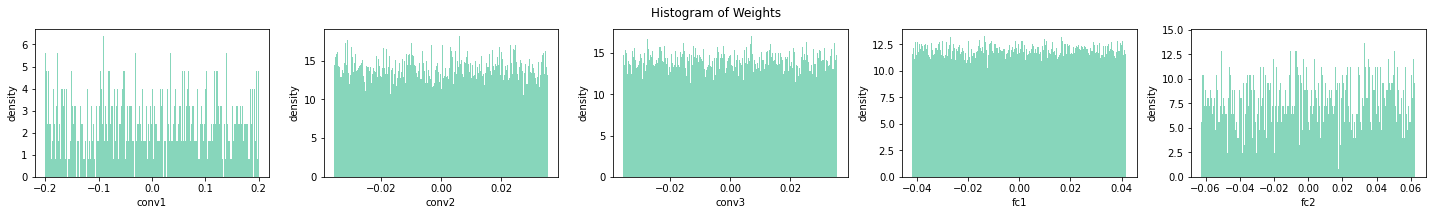

In [20]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(1,5, figsize=(20, 3))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = '#d687a2')
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = '#87D6BB')
            ax.set_xlabel(name[:-7])
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()
# at initial weights values
plot_weight_distribution(model)

# Visualize the Demo Images

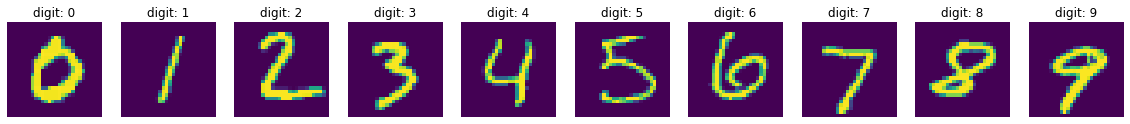

In [12]:
def visualize(with_predictions=False):
    plt.figure(figsize=(20, 10))
    predictions = model(demo_inputs).argmax(dim=1) if with_predictions else None
    for digit, index in demos.items():
        plt.subplot(1, 10, digit + 1)
        plt.imshow(demo_images[digit])
        if predictions is None:
            plt.title(f"digit: {digit}")
        else:
            plt.title(f"digit: {digit}\npred: {int(predictions[digit])}")
        plt.axis('off')
    plt.show()

visualize()

In [ ]:
demo_images[digit].shape

(28, 28)

# Pre-train Neural Network on MNIST

In [21]:
lr = 1
lr_step_gamma = 0.7
num_epochs = 5

optimizer = Adadelta(model.parameters(), lr=lr)
criterion = F.nll_loss
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_accuracy = 0
best_checkpoint = dict()
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(best_checkpoint['state_dict'])

train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  1 Accuracy 98.37% / Best Accuracy: 98.37%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  2 Accuracy 98.86% / Best Accuracy: 98.86%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  3 Accuracy 99.16% / Best Accuracy: 99.16%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  4 Accuracy 99.29% / Best Accuracy: 99.29%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  5 Accuracy 99.30% / Best Accuracy: 99.30%
=> loading best checkpoint


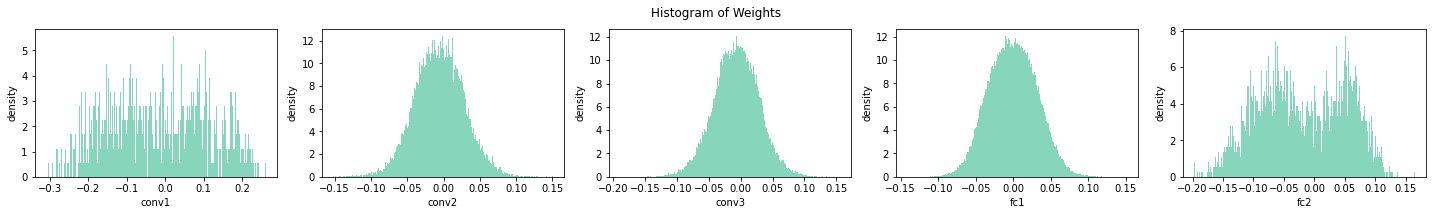

In [22]:
plot_weight_distribution(model)

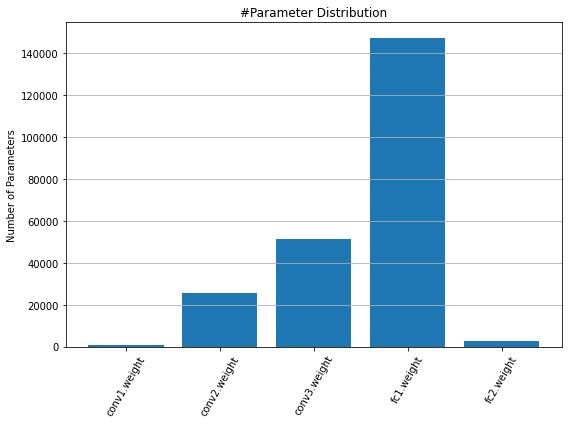

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

dense model has accuracy=99.29%
dense model has size=0.87 MiB


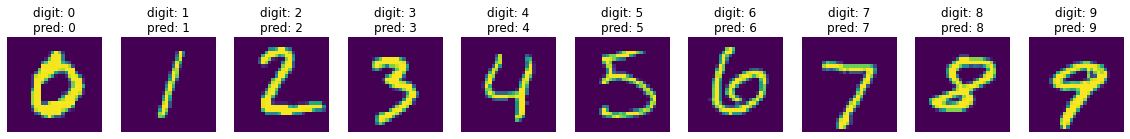

In [15]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
visualize(True)

In [ ]:
sparcities = np.arange(0.4,1.05,0.05)
accuracy = []
for sparsity in sparcities:
  recover_model()
  pruner = FineGrainedPruner(model, sparsity)
  pruner.apply(model)
  sparse_model_accuracy = evaluate(model, dataloader['test'])
  accuracy.append(sparse_model_accuracy)
  sparse_model_size = get_model_size(model, count_nonzero_only=True)
  print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
  print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
        f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
        f"the {dense_model_size/MiB:.2f} MiB dense model")
# visualize(True)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

40.0% sparse model has accuracy=99.29%
40.0% sparse model has size=0.52 MiB, which is 1.66X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

45.0% sparse model has accuracy=99.25%
45.0% sparse model has size=0.48 MiB, which is 1.82X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

50.0% sparse model has accuracy=99.19%
50.0% sparse model has size=0.44 MiB, which is 2.00X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

55.00000000000001% sparse model has accuracy=99.19%
55.00000000000001% sparse model has size=0.39 MiB, which is 2.22X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

60.0% sparse model has accuracy=98.87%
60.0% sparse model has size=0.35 MiB, which is 2.49X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

64.99999999999999% sparse model has accuracy=98.14%
64.99999999999999% sparse model has size=0.31 MiB, which is 2.85X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

70.0% sparse model has accuracy=93.57%
70.0% sparse model has size=0.26 MiB, which is 3.32X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

75.0% sparse model has accuracy=82.45%
75.0% sparse model has size=0.22 MiB, which is 3.98X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

80.0% sparse model has accuracy=43.66%
80.0% sparse model has size=0.18 MiB, which is 4.97X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

84.99999999999999% sparse model has accuracy=25.63%
84.99999999999999% sparse model has size=0.13 MiB, which is 6.60X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

89.99999999999999% sparse model has accuracy=15.58%
89.99999999999999% sparse model has size=0.09 MiB, which is 9.85X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

94.99999999999999% sparse model has accuracy=11.28%
94.99999999999999% sparse model has size=0.04 MiB, which is 19.36X smaller than the 0.87 MiB dense model


eval:   0%|          | 0/10 [00:00<?, ?it/s]

99.99999999999999% sparse model has accuracy=9.74%
99.99999999999999% sparse model has size=0.00 MiB, which is 578.71X smaller than the 0.87 MiB dense model


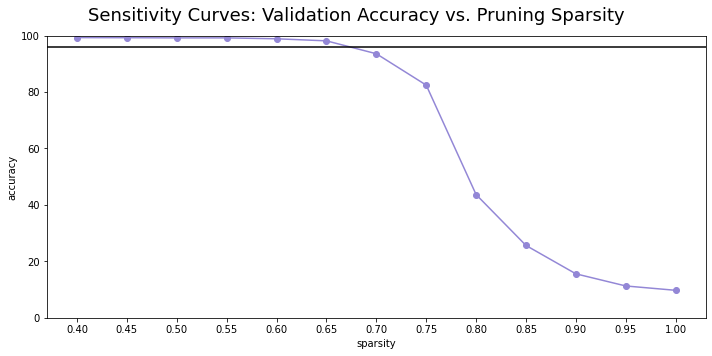

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(10,5))


curve = axes.plot(sparcities, accuracy,color = '#9387d6',marker = 'o')
line = axes.axhline(y = 96,color = 'k')
axes.set_xticks(np.arange(start=0.4, stop=1.05, step=0.05))
axes.set_ylim(0, 100)
axes.set_xlabel('sparsity')
axes.set_ylabel('accuracy')

fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity',fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [ ]:
recover_model()
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.05, scan_start=0.4, scan_end=1.0)

scanning 0/5 weight - conv1.weight:   0%|          | 0/12 [00:00<?, ?it/s]

    sparsity=[0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]: accuracy=[99.23%, 99.25%, 99.26%, 99.23%, 98.99%, 98.27%, 95.16%, 90.96%, 76.42%, 77.93%, 61.53%, 60.07%]

scanning 1/5 weight - conv2.weight:   0%|          | 0/12 [00:00<?, ?it/s]

    sparsity=[0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]: accuracy=[99.27%, 99.28%, 99.27%, 99.30%, 99.29%, 99.29%, 99.26%, 99.26%, 99.29%, 99.25%, 99.25%, 97.61%]

scanning 2/5 weight - conv3.weight:   0%|          | 0/12 [00:00<?, ?it/s]

    sparsity=[0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]: accuracy=[99.27%, 99.27%, 99.27%, 99.30%, 99.33%, 99.32%, 99.32%, 99.28%, 99.26%, 99.31%, 99.25%, 99.01%]

scanning 3/5 weight - fc1.weight:   0%|          | 0/12 [00:00<?, ?it/s]

    sparsity=[0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]: accuracy=[99.26%, 99.27%, 99.27%, 99.26%, 99.24%, 99.26%, 99.26%, 99.25%, 99.26%, 99.25%, 99.19%, 98.91%]

scanning 4/5 weight - fc2.weight:   0%|          | 0/12 [00:00<?, ?it/s]

    sparsity=[0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]: accuracy=[99.25%, 99.23%, 99.25%, 99.27%, 99.28%, 99.20%, 99.29%, 99.27%, 99.16%, 99.06%, 98.87%, 86.90%]

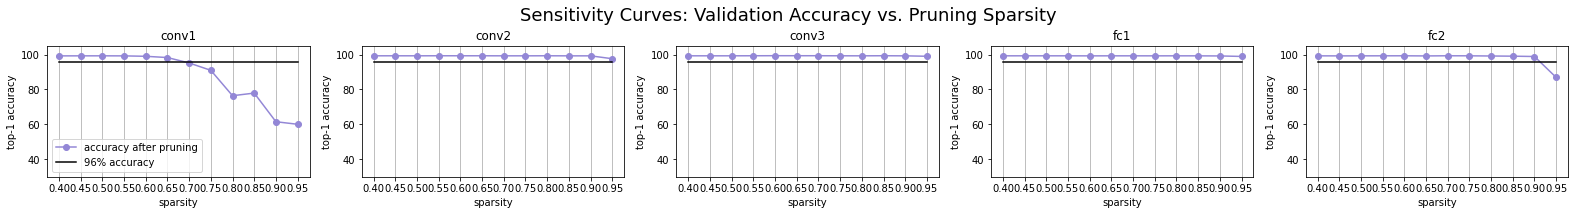

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies):
    lower_bound_accuracy = 96
    fig, axes = plt.subplots(1,5,figsize=(22,3))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index],color = '#9387d6',marker = 'o')
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities),color = 'k')
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.05))
            ax.set_ylim(30, 105)
            ax.set_title(name[:-7])
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            if plot_index == 0:
              ax.legend([
                  'accuracy after pruning',
                  f'{lower_bound_accuracy}% accuracy'
              ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity',fontsize = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies)

# Evaluate the Accuracy and Model Size of Dense Model

eval:   0%|          | 0/10 [00:00<?, ?it/s]

dense model has accuracy=99.27%
dense model has size=0.87 MiB


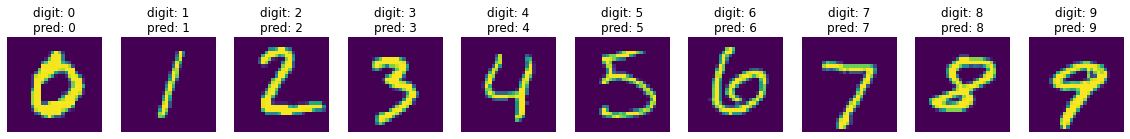

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
visualize(True)

# Prune the Model and Re-Evaluate the Accuracy.

In [ ]:
recover_model()

sparsity_dict = {
    'conv1.weight': 0.55,
    'conv2.weight': 0.8,
    'conv3.weight': 0.9,
    'fc1.weight': 0.9,
    'fc2.weight': 0.6
}

After pruning with sparsity dictionary
  conv1.weight: 0.55
  conv2.weight: 0.80
  conv3.weight: 0.90
  fc1.weight: 0.90
  fc2.weight: 0.60
The sparsity of each layer becomes
  conv1.weight: 0.55
  conv2.weight: 0.80
  conv3.weight: 0.90
  fc1.weight: 0.90
  fc2.weight: 0.60
Sparse model has size=0.10 MiB = 11.74% of dense model size


eval:   0%|          | 0/10 [00:00<?, ?it/s]

Sparse model has accuracy=96.46% before fintuning


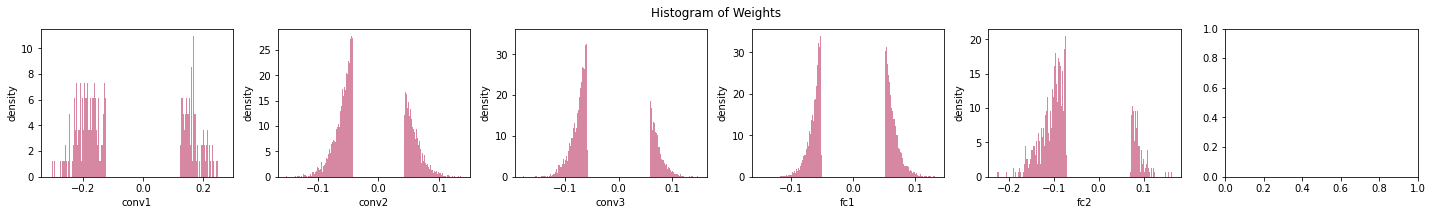

In [ ]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

In [23]:
recover_model()

sparsity_dict = {

    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'conv1.weight': 0.65,
    'conv2.weight': 0.95,
    'conv3.weight': 0.98,
    'fc1.weight': 0.98,
    'fc2.weight': 0.9
}

After pruning with sparsity dictionary
  conv1.weight: 0.65
  conv2.weight: 0.95
  conv3.weight: 0.98
  fc1.weight: 0.98
  fc2.weight: 0.90
The sparsity of each layer becomes
  conv1.weight: 0.65
  conv2.weight: 0.95
  conv3.weight: 0.98
  fc1.weight: 0.98
  fc2.weight: 0.90
Sparse model has size=0.02 MiB = 2.71% of dense model size


eval:   0%|          | 0/10 [00:00<?, ?it/s]

Sparse model has accuracy=11.35% before fintuning


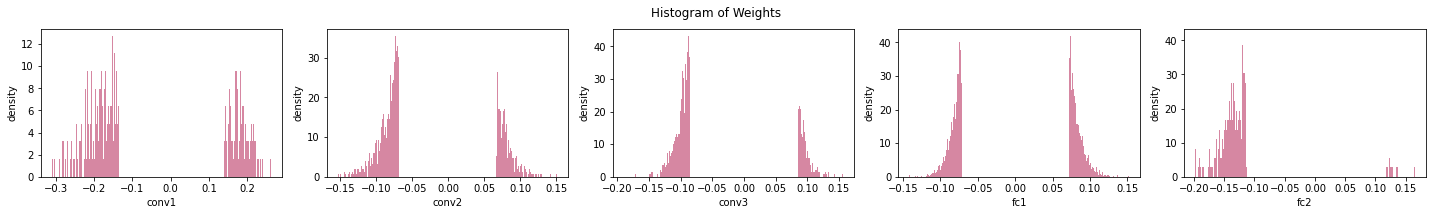

In [24]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

After pruning with sparsity dictionary
Sparse model has size=0.28 MiB = 32.12% of dense model size


eval:   0%|          | 0/10 [00:00<?, ?it/s]

Sparse model has accuracy=97.26% before fintuning


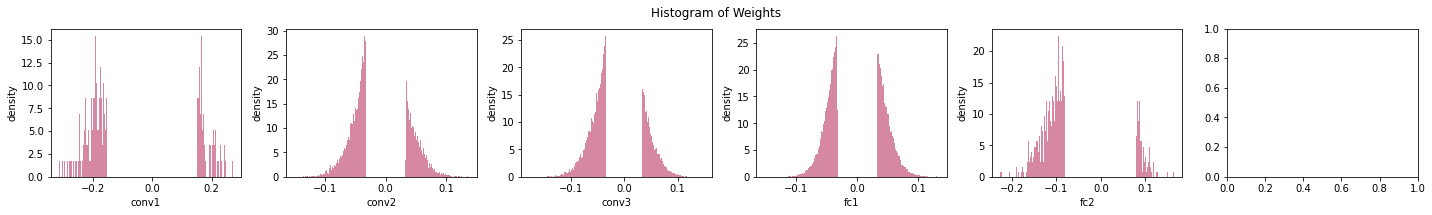

In [ ]:
recover_model()
sparsity_dict = 0.68
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')



sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

# Fine-tune the Pruned Model to Get Higher Accuracy

In [25]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask 
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'    Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')


Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 96.76% / Best Sparse Accuracy: 96.76%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 97.03% / Best Sparse Accuracy: 97.03%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 3 Sparse Accuracy 97.43% / Best Sparse Accuracy: 97.43%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 4 Sparse Accuracy 97.42% / Best Sparse Accuracy: 97.43%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 5 Sparse Accuracy 97.39% / Best Sparse Accuracy: 97.43%


eval:   0%|          | 0/10 [00:00<?, ?it/s]

90.0% sparse model has accuracy=97.76%
90.0% sparse model has size=0.02 MiB, which is 36.88X smaller than the 0.87 MiB dense model


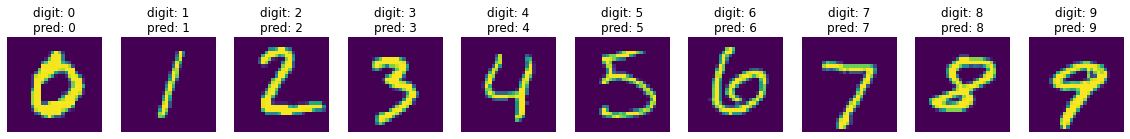

In [ ]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

In [ ]:
# helper functions to measure latency of a regular PyTorch models. 
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)', 
                            round(original_latency * 1000, 1), 
                            round(pruned_latency * 1000, 1), 
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)', 
                            round(original_macs / 1e6), 
                            round(pruned_macs / 1e6), 
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)', 
                            round(original_param / 1e6, 2), 
                            round(pruned_param / 1e6, 2), 
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio


NameError: ignored